In [17]:
import pandas as pd
from pathlib import Path
import torch
import pickle
import numpy as np
import json
from sklearn.metrics import average_precision_score
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import string

class Dict(dict):
    def __missing__(self, key):
        return key
        
tests =  ['Conf', 'Unconf', 'Reverse', 'Real']
metrics = ['acc', 'auc']
all_metrics = [i + ' ' + j for j in metrics for i in tests] 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)

In [33]:
# plotting
renames_test = Dict({
    'Conf': 'Conf Test',
    'Unconf': 'Unconf Test',
    'Reverse': 'Rev-Conf Test',
    'Real': 'Real Test'    
})

renames_method = Dict({
    'Conf': 'Simple',
    'Deconf': 'CB'  
})

renames_types = Dict({
    'back': 'Observed',
    'front': 'Obs. with Mediator',
    'back_front': 'Unobs. with Mediator',
    'label_flip': 'Biased Care',    
})

renames_metrics = Dict({
    'auc': 'AUC',
    'auprc': 'AUPRC',
    'acc': 'Accuracy',  
})

rename_ds = Dict(
{
    'Camelyon': 'Camelyon17',
    'CXR': 'MIMIC-CXP',
    'Poverty': 'PovertyMap'}
)

linestyles = {
    'Conf': ':',
    'Unconf': '--',
    'Reverse': '-',
    'Real': '-.'
}

markers = {
    'IF': '+',
    'Conf':  'o',
    'Deconf': 's',
    'DA': '*'   
}

colors = {
    'IF':'#E61D51',
    'Conf': '#2BABA9',
    'Deconf': '#000000',
    'DA': '#F1B355'
}

MS = 6.0
LW=1.5
CS=6.0
FZ=24.0

In [19]:
all_dfs = {}

## Camelyon

In [20]:
root_dir = Path('/scratch/ssd001/home/haoran/wilds_results/Camelyon1')

In [21]:
ress = []
for path in root_dir.glob('**/done'):
    res = pickle.load((path.parent/'final_results.p').open('rb'))
    args = json.load((path.parent/'args.json').open('r'))
    for i in args:
        res[i] = args[i]
#     if 'Unconf auprc' not in res:
#         for test in tests:
#             if f'{test} target' in res:
#                 res[f'{test} auprc'] = average_precision_score(res[f'{test} target'], res[f'{test} pred'])
    ress.append(res)

In [22]:
df = pd.DataFrame(ress)[['type', 'data_type', 'corr_coff', 'domains',  'seed'] + all_metrics]
df['domains'] = df['domains'].apply(lambda x: tuple(x))

In [23]:
res_df = df.groupby(['type', 'corr_coff', 'data_type']).agg({i: ('mean', 'std') for i in all_metrics})
all_dfs['Camelyon'] = res_df

## CXR

In [24]:
root_dir = Path('/scratch/ssd001/home/haoran/wilds_results/CXR1')

In [25]:
ress = []
for path in root_dir.glob('**/done'):
    res = pickle.load((path.parent/'final_results.p').open('rb'))
    args = json.load((path.parent/'args.json').open('r'))
    for i in args:
        res[i] = args[i]
    if 'Unconf auprc' not in res:
        for test in tests:
            if f'{test} target' in res:
                res[f'{test} auprc'] = average_precision_score(res[f'{test} target'], res[f'{test} pred'])
    ress.append(res)

In [26]:
df = pd.DataFrame(ress)[['type', 'data_type', 'corr_coff',  'seed'] + all_metrics]

In [27]:
res_df = df.groupby(['type', 'corr_coff', 'data_type']).agg({i: ('mean', 'std') for i in all_metrics})
all_dfs['CXR'] = res_df

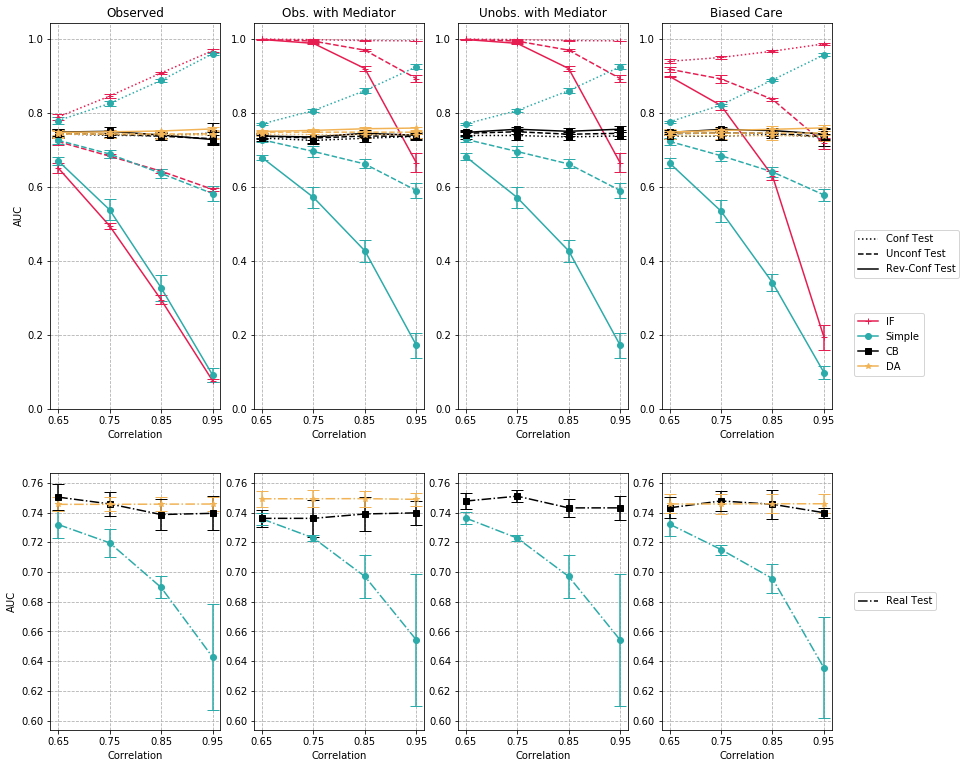

In [8]:
metric = 'auc'
unify_first_row_y = True
fig, axs = plt.subplots(2, 4, figsize=[14,13], gridspec_kw={'height_ratios': [1.5, 1]})
for row in range(2):
    if row == 0:
        test_types = ['Conf', 'Unconf', 'Reverse']
    else:
        test_types = ['Real']
    
    for c, i in enumerate(renames_types.keys()):
        temp = res_df.query(f'type == "{i}"').reset_index()
        ax = axs[row][c]
        for method in markers.keys():
            if method == 'DA' and i == 'back_front':
                continue
            
            for test_type in test_types:
                colname = f'{test_type} {metric}'
                subset = temp[(temp.data_type == method)][[colname, 'corr_coff']]                
                ax.errorbar(subset['corr_coff'], subset[(colname, 'mean')], subset[(colname, 'std')], marker = markers[method], 
                        linestyle = linestyles[test_type], color = colors[method],
                       markersize = MS,  linewidth=LW, capsize=CS)
                ax.grid(which='both', linestyle='--')
                ax.set_xticks(subset.corr_coff.unique())
                            
        if row == 0:
            ax.set_title(renames_types[i])
        if c == 0:
            ax.set_ylabel(renames_metrics[metric])
        ax.set_xlabel('Correlation')
            
    # go back and set ylims
    if row == 1 or unify_first_row_y:
        ymin_min, ymax_max = 1, 0
        for ax in axs[row]:
            ymin, ymax = ax.get_ylim()
            ymin_min = min(ymin, ymin_min)
            ymax_max = max(ymax, ymax_max)
        if ymin_min < 0.05:
            ymin_min = 0.0
        for ax in axs[row]:
            ax.set_ylim(bottom = ymin_min, top = ymax_max)
            
            
            
# make custom legend
tests_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = linestyles[test_type], color = 'k',
                 label = renames_test[test_type]) for test_type in ['Conf', 'Unconf', 'Reverse']
]
real_tests_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = linestyles[test_type], color = 'k',
                 label = renames_test[test_type]) for test_type in ['Real']
]
methods_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = '-', color = colors[method], marker = markers[method], markersize = MS,
                 label = renames_method[method]) for method in colors.keys()
]

# fig.subplots_adjust(right=0.9)
axs[0][-1].legend(handles = tests_legend, loc='center left', bbox_to_anchor=(1.1, 0.4))  
leg2 = axs[1][-1].legend(handles = methods_legend, loc='center left', bbox_to_anchor=(1.1, 1.5))
leg3 = axs[1][-1].legend(handles = real_tests_legend, loc='center left', bbox_to_anchor=(1.1, 0.5))
ax.add_artist(leg2)

plt.savefig(f'figures/CXR_{metric}.pdf',dpi=300, bbox_inches = 'tight')       

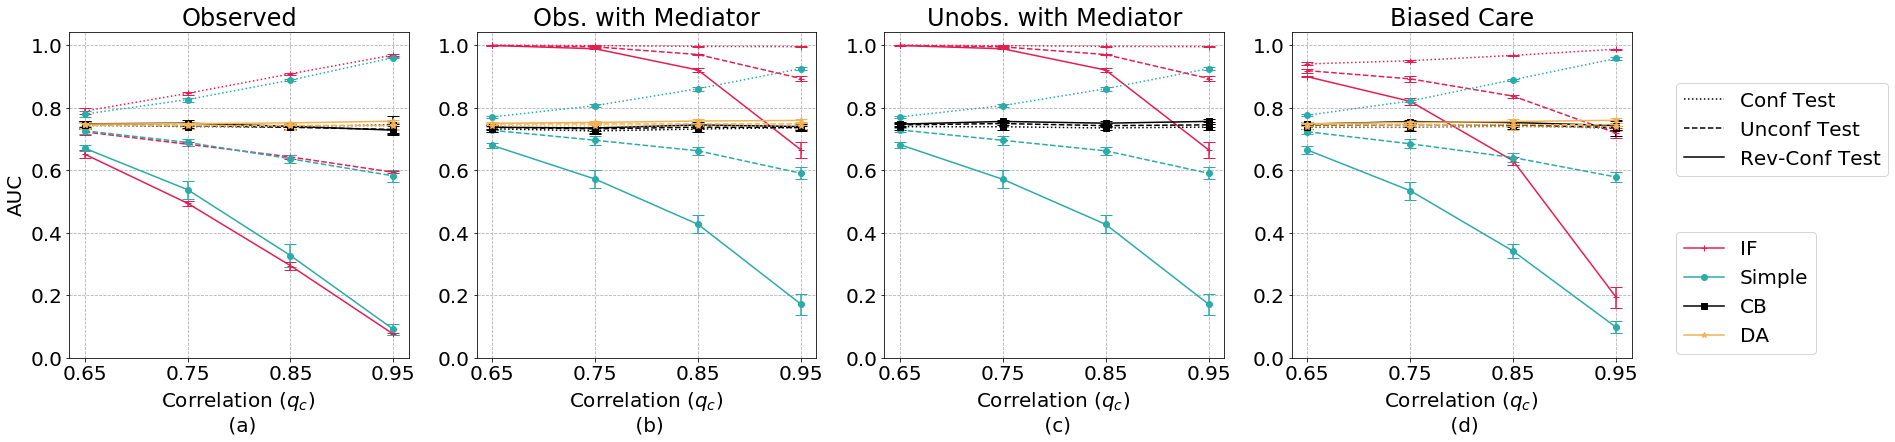

In [16]:
# v2
metric = 'auc'
plt.rcParams.update({'font.size': 20})
unify_first_row_y = True
fig, axs = plt.subplots(1, 4, figsize=[28,6])
test_types = ['Conf', 'Unconf', 'Reverse']

for c, i in enumerate(renames_types.keys()):
    temp = res_df.query(f'type == "{i}"').reset_index()
    ax = axs[c]
    for method in markers.keys():
        if method == 'DA' and i == 'back_front':
            continue

        for test_type in test_types:
            colname = f'{test_type} {metric}'
            subset = temp[(temp.data_type == method)][[colname, 'corr_coff']]                
            ax.errorbar(subset['corr_coff'], subset[(colname, 'mean')], subset[(colname, 'std')], marker = markers[method], 
                    linestyle = linestyles[test_type], color = colors[method],
                   markersize = MS,  linewidth=LW, capsize=CS)
            ax.grid(which='both', linestyle='--')
            ax.set_xticks(subset.corr_coff.unique())

    ax.set_title(renames_types[i])
    if c == 0:
        ax.set_ylabel(renames_metrics[metric])
    ax.set_xlabel(f'Correlation ($q_c$) \n ({string.ascii_lowercase[c]})')

# go back and set ylims
if unify_first_row_y:
    ymin_min, ymax_max = 1, 0
    for ax in axs:
        ymin, ymax = ax.get_ylim()
        ymin_min = min(ymin, ymin_min)
        ymax_max = max(ymax, ymax_max)
    if ymin_min < 0.05:
        ymin_min = 0.0
    for ax in axs:
        ax.set_ylim(bottom = ymin_min, top = ymax_max)
                        
            
# make custom legend
tests_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = linestyles[test_type], color = 'k',
                 label = renames_test[test_type]) for test_type in test_types
]
methods_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = '-', color = colors[method], marker = markers[method], markersize = MS,
                 label = renames_method[method]) for method in colors.keys()
]

# fig.subplots_adjust(right=0.9)
leg1 = axs[-1].legend(handles = tests_legend, loc='center left', bbox_to_anchor=(1.1, 0.7))  
leg2 = axs[-1].legend(handles = methods_legend, loc='center left', bbox_to_anchor=(1.1, 0.2))
ax.add_artist(leg1)

plt.savefig(f'figures/CXR_{metric}_merged.pdf',dpi=300, bbox_inches = 'tight')       

## Poverty

In [28]:
root_dir = Path('/scratch/ssd001/home/haoran/wilds_results/Poverty1')

In [29]:
ress = []
for path in root_dir.glob('**/done'):
    res = pickle.load((path.parent/'final_results.p').open('rb'))
    args = json.load((path.parent/'args.json').open('r'))
    for i in args:
        res[i] = args[i]
    if 'Unconf auprc' not in res:
        for test in tests:
            if f'{test} target' in res:
                res[f'{test} auprc'] = average_precision_score(res[f'{test} target'], res[f'{test} pred'])
    ress.append(res)

In [30]:
df = pd.DataFrame(ress)[['type', 'data_type', 'corr_coff', 'seed'] + all_metrics]

In [31]:
res_df = df.groupby(['type', 'corr_coff', 'data_type']).agg({i: ('mean', 'std') for i in all_metrics})
all_dfs['Poverty'] = res_df

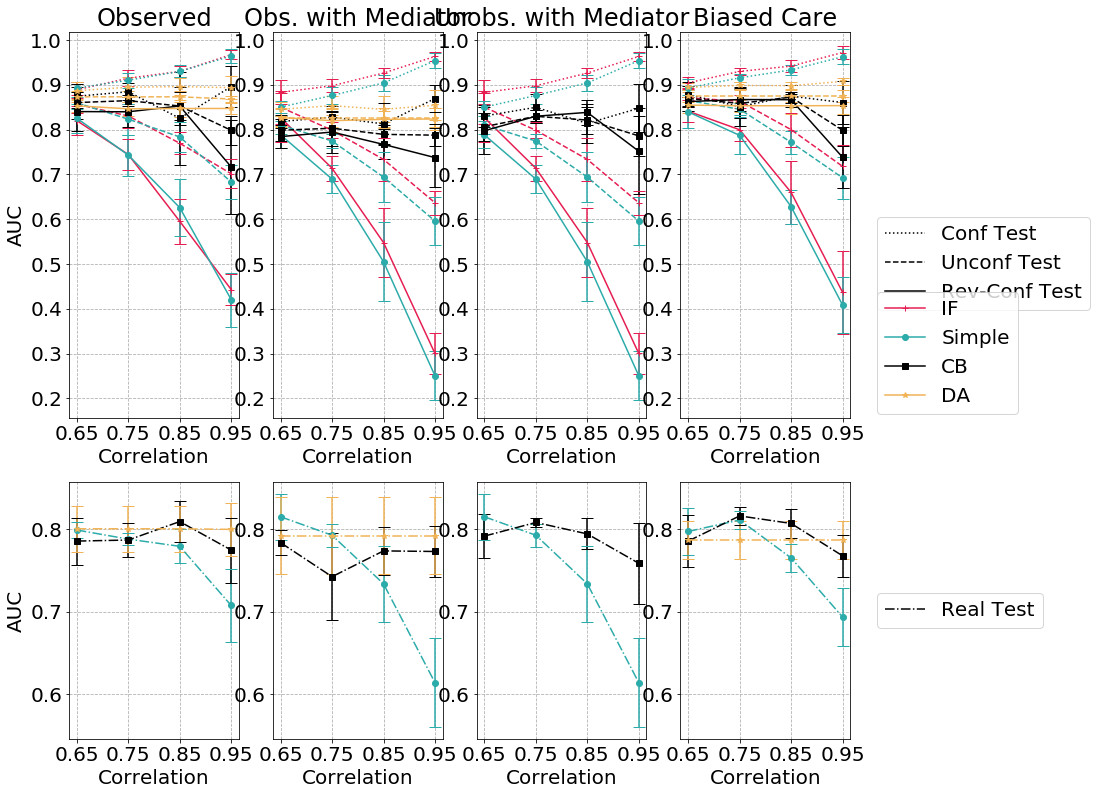

In [29]:
metric = 'auc'
unify_first_row_y = True
fig, axs = plt.subplots(2, 4, figsize=[14,13], gridspec_kw={'height_ratios': [1.5, 1]})
for row in range(2):
    if row == 0:
        test_types = ['Conf', 'Unconf', 'Reverse']
    else:
        test_types = ['Real']
    
    for c, i in enumerate(renames_types.keys()):
        temp = res_df.query(f'type == "{i}"').reset_index()
        ax = axs[row][c]
        for method in markers.keys():
            if method == 'DA' and i == 'back_front':
                continue
            
            for test_type in test_types:
                colname = f'{test_type} {metric}'
                subset = temp[(temp.data_type == method)][[colname, 'corr_coff']]                
                ax.errorbar(subset['corr_coff'], subset[(colname, 'mean')], subset[(colname, 'std')], marker = markers[method], 
                        linestyle = linestyles[test_type], color = colors[method],
                       markersize = MS,  linewidth=LW, capsize=CS)
                ax.grid(which='both', linestyle='--')
                ax.set_xticks(subset.corr_coff.unique())
                            
        if row == 0:
            ax.set_title(renames_types[i])
        if c == 0:
            ax.set_ylabel(renames_metrics[metric])
        ax.set_xlabel('Correlation')
            
    # go back and set ylims
    if row == 1 or unify_first_row_y:
        ymin_min, ymax_max = 1, 0
        for ax in axs[row]:
            ymin, ymax = ax.get_ylim()
            ymin_min = min(ymin, ymin_min)
            ymax_max = max(ymax, ymax_max)
        if ymin_min < 0.05:
            ymin_min = 0.0
        for ax in axs[row]:
            ax.set_ylim(bottom = ymin_min, top = ymax_max)
                        
            
# make custom legend
tests_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = linestyles[test_type], color = 'k',
                 label = renames_test[test_type]) for test_type in ['Conf', 'Unconf', 'Reverse']
]
real_tests_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = linestyles[test_type], color = 'k',
                 label = renames_test[test_type]) for test_type in ['Real']
]
methods_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = '-', color = colors[method], marker = markers[method], markersize = MS,
                 label = renames_method[method]) for method in colors.keys()
]

# fig.subplots_adjust(right=0.9)
axs[0][-1].legend(handles = tests_legend, loc='center left', bbox_to_anchor=(1.1, 0.4))  
leg2 = axs[1][-1].legend(handles = methods_legend, loc='center left', bbox_to_anchor=(1.1, 1.5))
leg3 = axs[1][-1].legend(handles = real_tests_legend, loc='center left', bbox_to_anchor=(1.1, 0.5))
ax.add_artist(leg2)

plt.savefig(f'figures/poverty_{metric}.pdf',dpi=300, bbox_inches = 'tight')       

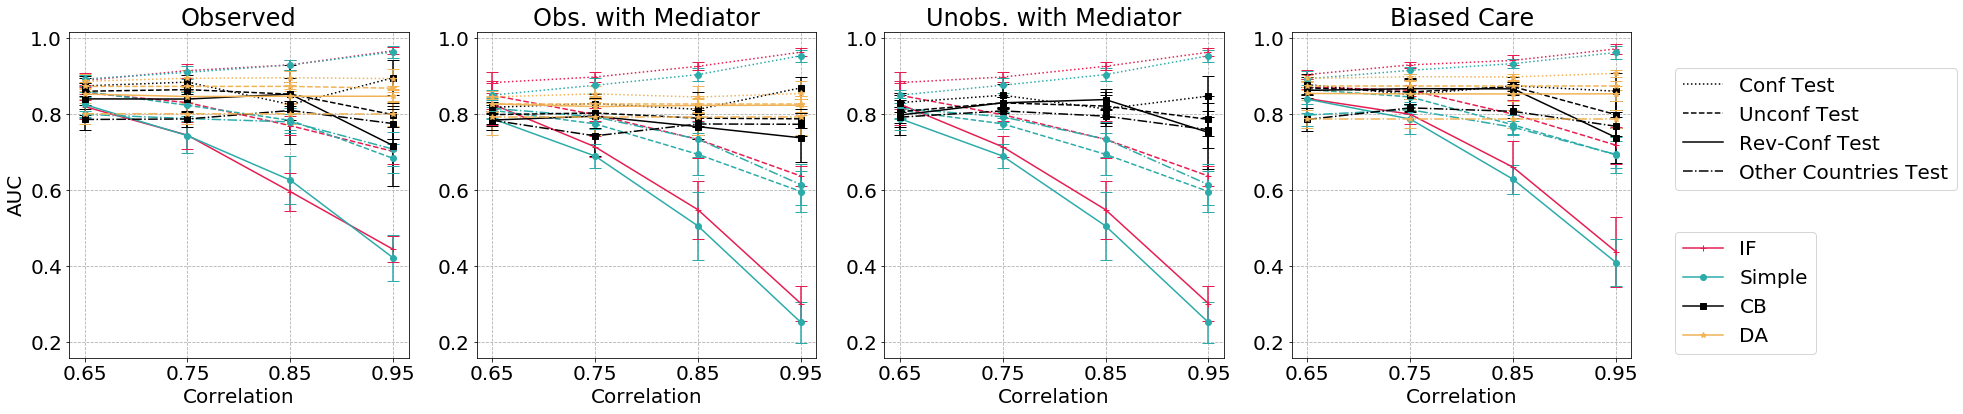

In [9]:
# v2
metric = 'auc'
plt.rcParams.update({'font.size': 20})
unify_first_row_y = True
fig, axs = plt.subplots(1, 4, figsize=[28,6])
test_types = ['Conf', 'Unconf', 'Reverse', 'Real']

for c, i in enumerate(renames_types.keys()):
    temp = res_df.query(f'type == "{i}"').reset_index()
    ax = axs[c]
    for method in markers.keys():
        if method == 'DA' and i == 'back_front':
            continue

        for test_type in test_types:
            colname = f'{test_type} {metric}'
            subset = temp[(temp.data_type == method)][[colname, 'corr_coff']]                
            ax.errorbar(subset['corr_coff'], subset[(colname, 'mean')], subset[(colname, 'std')], marker = markers[method], 
                    linestyle = linestyles[test_type], color = colors[method],
                   markersize = MS,  linewidth=LW, capsize=CS)
            ax.grid(which='both', linestyle='--')
            ax.set_xticks(subset.corr_coff.unique())

    ax.set_title(renames_types[i])
    if c == 0:
        ax.set_ylabel(renames_metrics[metric])
    ax.set_xlabel('Correlation')

# go back and set ylims
if unify_first_row_y:
    ymin_min, ymax_max = 1, 0
    for ax in axs:
        ymin, ymax = ax.get_ylim()
        ymin_min = min(ymin, ymin_min)
        ymax_max = max(ymax, ymax_max)
    if ymin_min < 0.05:
        ymin_min = 0.0
    for ax in axs:
        ax.set_ylim(bottom = ymin_min, top = ymax_max)
                        
            
# make custom legend
tests_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = linestyles[test_type], color = 'k',
                 label = renames_test[test_type]) for test_type in ['Conf', 'Unconf', 'Reverse', 'Real']
]
methods_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = '-', color = colors[method], marker = markers[method], markersize = MS,
                 label = renames_method[method]) for method in colors.keys()
]

# fig.subplots_adjust(right=0.9)
leg1 = axs[-1].legend(handles = tests_legend, loc='center left', bbox_to_anchor=(1.1, 0.7))  
leg2 = axs[-1].legend(handles = methods_legend, loc='center left', bbox_to_anchor=(1.1, 0.2))
ax.add_artist(leg1)

plt.savefig(f'figures/Poverty_{metric}_merged.pdf',dpi=300, bbox_inches = 'tight')       

## All Plots

In [32]:
sub = ['Camelyon', 'CXR', 'Poverty']
# sub = ['Camelyon', 'Poverty']
ind = len(sub)

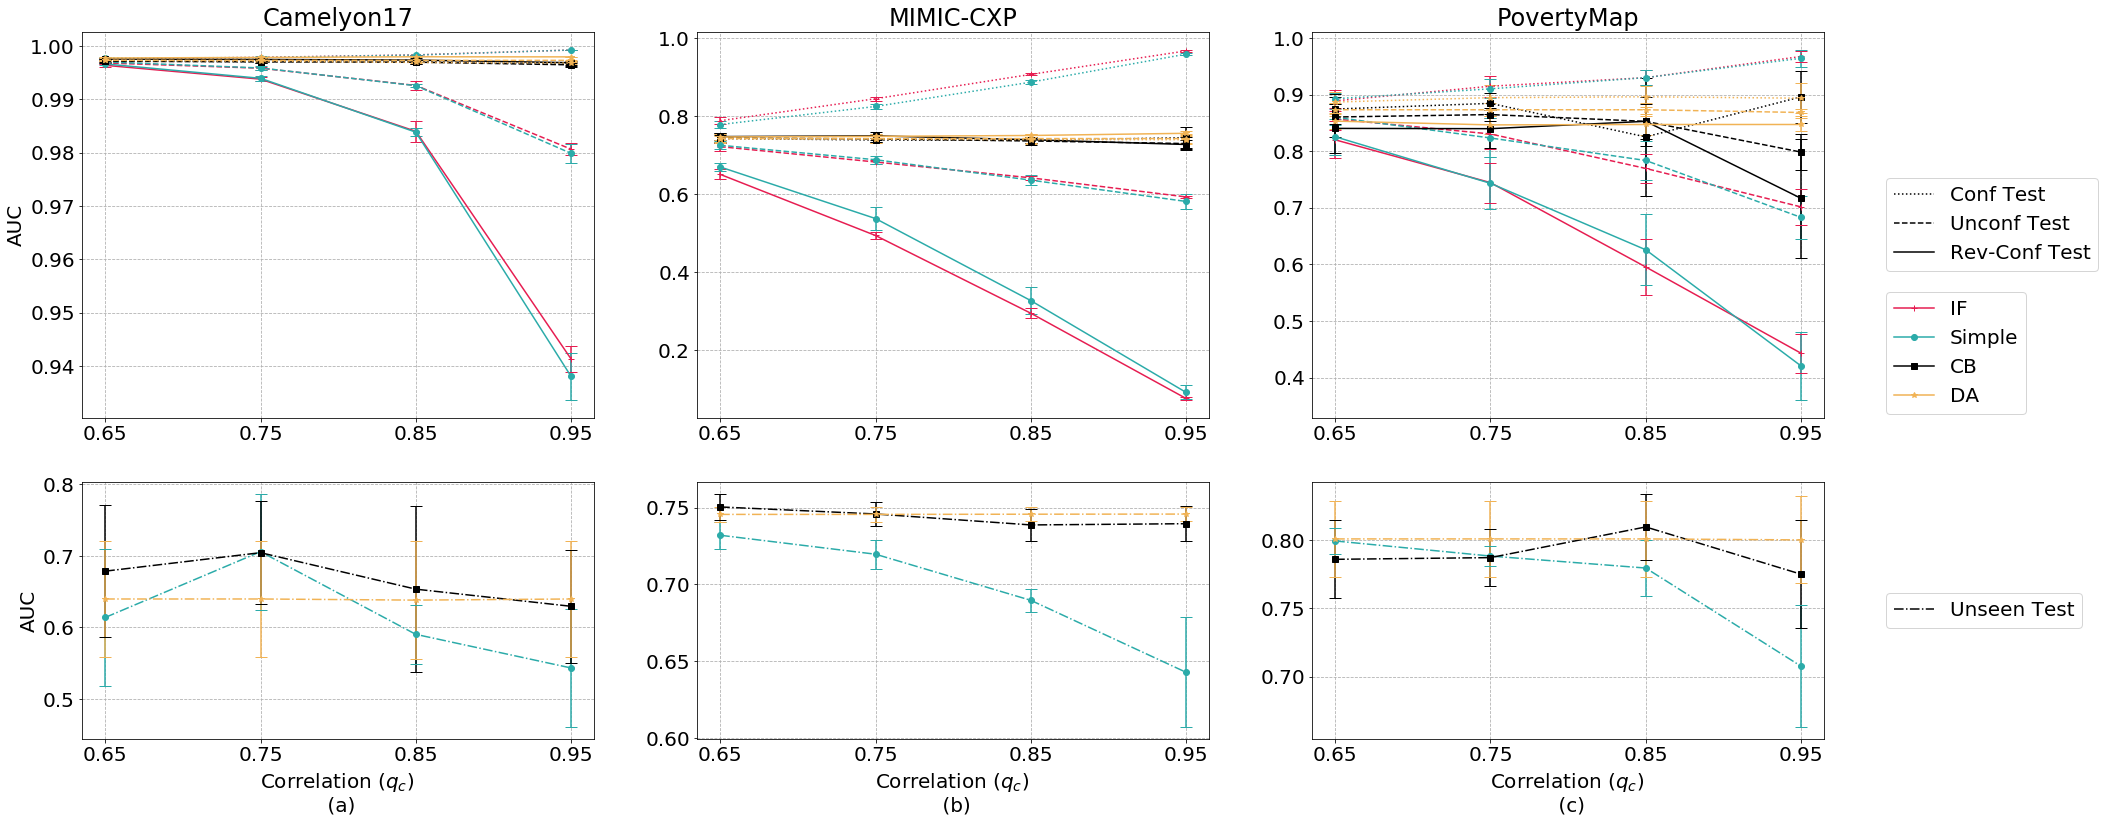

In [36]:
metric = 'auc'
unify_first_row_y = True
fig, axs = plt.subplots(2, ind, figsize=[22*(ind/3),13], gridspec_kw={'height_ratios': [1.5, 1]})
for row in range(2):
    if row == 0:
        test_types = ['Conf', 'Unconf', 'Reverse']
    else:
        test_types = ['Real']
    
    for c, i in enumerate(sub):
        temp = all_dfs[i].query(f'type == "back"').reset_index()
        ax = axs[row][c]
        for method in markers.keys():
            for test_type in test_types:
                colname = f'{test_type} {metric}'
                subset = temp[(temp.data_type == method)][[colname, 'corr_coff']]                
                ax.errorbar(subset['corr_coff'], subset[(colname, 'mean')], subset[(colname, 'std')], marker = markers[method], 
                        linestyle = linestyles[test_type], color = colors[method],
                       markersize = MS,  linewidth=LW, capsize=CS)
                ax.grid(which='both', linestyle='--')
                ax.set_xticks(subset.corr_coff.unique())
                            
        if row == 0:
            ax.set_title(rename_ds[i])
        if c == 0:
            ax.set_ylabel(renames_metrics[metric])
            
        if row == 1:
            ax.set_xlabel(f'Correlation ($q_c$) \n ({string.ascii_lowercase[c]})')
            
            
# make custom legend
tests_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = linestyles[test_type], color = 'k',
                 label = renames_test[test_type]) for test_type in ['Conf', 'Unconf', 'Reverse']
]
real_tests_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = linestyles[test_type], color = 'k',
                 label = 'Unseen Test') for test_type in ['Real']
]
methods_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = '-', color = colors[method], marker = markers[method], markersize = MS,
                 label = renames_method[method]) for method in colors.keys()
]

# fig.subplots_adjust(right=0.9)
axs[0][-1].legend(handles = tests_legend, loc='center left', bbox_to_anchor=(1.1, 0.5))  
leg2 = axs[1][-1].legend(handles = methods_legend, loc='center left', bbox_to_anchor=(1.1, 1.5))
leg3 = axs[1][-1].legend(handles = real_tests_legend, loc='center left', bbox_to_anchor=(1.1, 0.5))
ax.add_artist(leg2)

plt.subplots_adjust(left=-0.2)
plt.savefig(f'figures/p{ind}.pdf',dpi=300, bbox_inches = 'tight')       

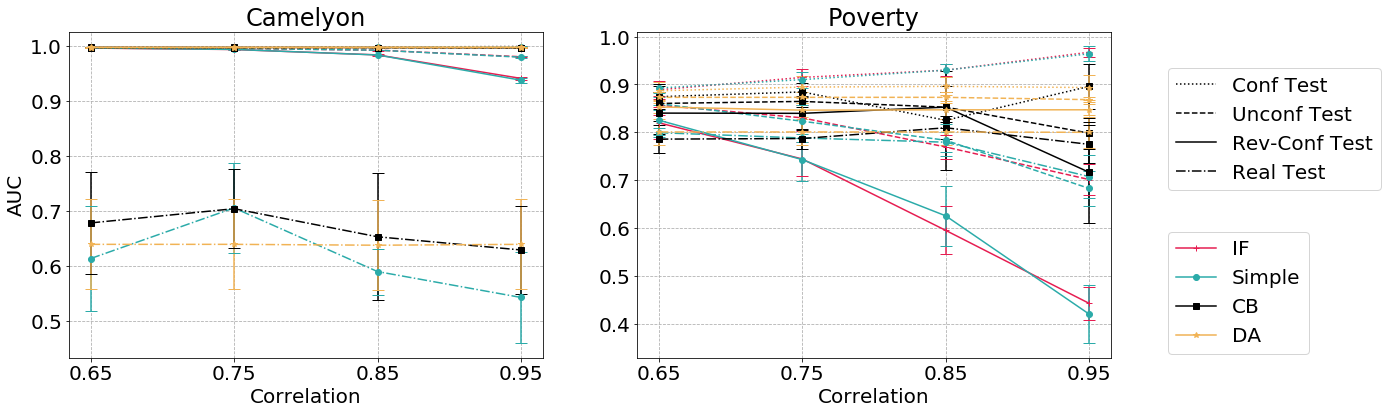

In [50]:
# v2
metric = 'auc'
unify_first_row_y = True
fig, axs = plt.subplots(1, ind, figsize=[28*(ind/3),6])
test_types = ['Conf', 'Unconf', 'Reverse', 'Real']

for c, i in enumerate(sub):
    temp = all_dfs[i].query(f'type == "back"').reset_index()
    ax = axs[c]
    for method in markers.keys():
        for test_type in test_types:
            colname = f'{test_type} {metric}'
            subset = temp[(temp.data_type == method)][[colname, 'corr_coff']]                
            ax.errorbar(subset['corr_coff'], subset[(colname, 'mean')], subset[(colname, 'std')], marker = markers[method], 
                    linestyle = linestyles[test_type], color = colors[method],
                   markersize = MS,  linewidth=LW, capsize=CS)
            ax.grid(which='both', linestyle='--')
            ax.set_xticks(subset.corr_coff.unique())

    ax.set_title(i)
    if c == 0:
        ax.set_ylabel(renames_metrics[metric])
    ax.set_xlabel('Correlation')

            
# make custom legend
tests_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = linestyles[test_type], color = 'k',
                 label = renames_test[test_type]) for test_type in ['Conf', 'Unconf', 'Reverse', 'Real']
]
methods_legend = [
    mlines.Line2D([], [], linewidth = LW, linestyle = '-', color = colors[method], marker = markers[method], markersize = MS,
                 label = renames_method[method]) for method in colors.keys()
]

# fig.subplots_adjust(right=0.9)
leg1 = axs[-1].legend(handles = tests_legend, loc='center left', bbox_to_anchor=(1.1, 0.7))  
leg2 = axs[-1].legend(handles = methods_legend, loc='center left', bbox_to_anchor=(1.1, 0.2))
ax.add_artist(leg1)

plt.savefig(f'figures/p{ind}_merged.pdf',dpi=300, bbox_inches = 'tight')       

## Env Predictor

In [62]:
root_dir = Path('/scratch/ssd001/home/haoran/wilds_results/EnvClf')

In [63]:
ress = []
for path in root_dir.glob('**/done'):
    res = pickle.load((path.parent/'final_results.p').open('rb'))
    args = json.load((path.parent/'args.json').open('r'))
    for i in args:
        res[i] = args[i]
    ress.append(res)

In [64]:
df = pd.DataFrame(ress)[['data', 'seed'] + metrics]

In [65]:
res_df = df.groupby(['data']).agg({i: ('mean', 'std') for i in metrics})

In [66]:
res_df

acc                 auc              
             mean       std      mean           std
data                                               
CXR      0.996606  0.000113  0.999822  1.307449e-05
CelebA   0.999950  0.000071  1.000000  4.968610e-08
MNIST    0.995500  0.000346  0.999899  1.505435e-05
NIH      0.999247  0.000258  0.999866  9.161058e-05
poverty  0.915586  0.007965  0.973956  5.016557e-03